# 自定义导数规则

<!--* freshness: { reviewed: '2024-04-08' } *-->

[![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/Custom_derivative_rules_for_Python_code.ipynb) [![在 Kaggle 中打开](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/google/jax/blob/main/docs/notebooks/Custom_derivative_rules_for_Python_code.ipynb)

在 JAX 中定义微分规则有两种方法：

1. 使用 `jax.custom_jvp` 和 `jax.custom_vjp` 为已经可以 JAX 转换的 Python 函数定义自定义微分规则；
2. 定义新的 `core.Primitive` 实例以及所有的变换规则，例如调用来自其他系统的函数，如求解器、模拟器或一般数值计算系统。

本笔记本是关于第一种方法。如果想了解第二种方法，请参见[添加原语的笔记本](https://jax.readthedocs.io/en/latest/notebooks/How_JAX_primitives_work.html)。

有关 JAX 的自动微分 API 的介绍，请参见[自动微分食谱](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html)。本笔记本假设读者对 [jax.jvp](https://jax.readthedocs.io/en/latest/jax.html#jax.jvp) 和 [jax.grad](https://jax.readthedocs.io/en/latest/jax.html#jax.grad) 及 JVP 和 VJP 的数学意义有一定的了解。


## 摘要


### 使用 `jax.custom_jvp` 的自定义 JVPs


In [2]:
import jax.numpy as jnp
from jax import custom_jvp

@custom_jvp
def f(x, y):
  return jnp.sin(x) * y

@f.defjvp
def f_jvp(primals, tangents):
  x, y = primals
  x_dot, y_dot = tangents
  primal_out = f(x, y)
  tangent_out = jnp.cos(x) * x_dot * y + jnp.sin(x) * y_dot
  return primal_out, tangent_out


In [3]:
from jax import jvp, grad

print(f(2., 3.))
y, y_dot = jvp(f, (2., 3.), (1., 0.))
print(y)
print(y_dot)
print(grad(f)(2., 3.))


2.7278922
2.7278922
-1.2484405
-1.2484405


In [4]:
# 使用defjvps便捷包装的等效替代方案

@custom_jvp
def f(x, y):
  return jnp.sin(x) * y

f.defjvps(lambda x_dot, primal_out, x, y: jnp.cos(x) * x_dot * y,
          lambda y_dot, primal_out, x, y: jnp.sin(x) * y_dot)


In [5]:
print(f(2., 3.))
y, y_dot = jvp(f, (2., 3.), (1., 0.))
print(y)
print(y_dot)
print(grad(f)(2., 3.))


2.7278922
2.7278922
-1.2484405
-1.2484405


### 使用 `jax.custom_vjp` 的自定义 VJP


In [6]:
from jax import custom_vjp

@custom_vjp
def f(x, y):
  return jnp.sin(x) * y

def f_fwd(x, y):
# 返回原始输出和残差，以供 f_bwd 在反向传播过程中使用。
  return f(x, y), (jnp.cos(x), jnp.sin(x), y)

def f_bwd(res, g):
  cos_x, sin_x, y = res # 获取在f_fwd中计算的残差
  return (cos_x * g * y, sin_x * g)

f.defvjp(f_fwd, f_bwd)


In [7]:
print(grad(f)(2., 3.))


-1.2484405


## 示例问题

为了了解 `jax.custom_jvp` 和 `jax.custom_vjp` 旨在解决的内容，让我们看几个示例。对 `jax.custom_jvp` 和 `jax.custom_vjp` API 的更详细介绍将在下一节中进行。


### 数值稳定性

`jax.custom_jvp` 的一个应用是提高微分的数值稳定性。


```markdown
假设我们想要编写一个名为 `log1pexp` 的函数，用于计算 $x \mapsto \log ( 1 + e^x )$。我们可以使用 `jax.numpy` 来实现：
```


In [8]:

def log1pexp(x):
  return jnp.log(1. + jnp.exp(x))

log1pexp(3.)


Array(3.0485873, dtype=float32)

由于它是用 `jax.numpy` 编写的，因此它可以进行 JAX 转换：


In [9]:
from jax import jit, grad, vmap

print(jit(log1pexp)(3.))
print(jit(grad(log1pexp))(3.))
print(vmap(jit(grad(log1pexp)))(jnp.arange(3.)))


3.0485873
0.95257413
[0.5        0.7310586  0.88079715]


但这里潜藏着一个数值稳定性问题：


In [10]:
print(grad(log1pexp)(100.))


nan


这似乎不对！毕竟，$x \mapsto \log (1 + e^x)$ 的导数是 $x \mapsto \frac{e^x}{1 + e^x}$，所以对于大的 $x$ 值，我们期望这个值大约为 1。

通过查看梯度计算的 jaxpr，我们可以更深入地了解发生了什么：


In [11]:
from jax import make_jaxpr

make_jaxpr(grad(log1pexp))(100.)


{ lambda  ; a.
  let b = exp a
      c = add b 1.0
      _ = log c
      d = div 1.0 c
      e = mul d b
  in (e,) }

逐步评估 jaxpr，我们可以看到最后一行将涉及到乘以浮点数学会四舍五入为 0 和 $\infty$ 的值， 这并不是一个好主意。也就是说，我们实际上在评估 `lambda x: (1 / (1 + jnp.exp(x))) * jnp.exp(x)` 对于大 `x`，这实际上变成了 `0. * jnp.inf`。

与其生成如此大的和小的值，寄希望于浮点数无法始终提供的消去效果，我们宁愿将导数函数表示为一个更数字稳定的程序。特别是，我们可以写一个程序，更加精确地评估等价的数学表达式 $1 - \frac{1}{1 + e^x}$，且没有消去现象。

这个问题很有趣，因为尽管我们对 `log1pexp` 的定义已经可以被 JAX 微分（并可以通过 `jit`、`vmap` 等进行变换），但我们对应用标准自动微分规则到组成 `log1pexp` 的原语并将结果组合在一起的结果并不满意。相反，我们希望指定如何整体上将整个函数 `log1pexp` 进行微分，作为一个单元，从而更好地安排那些指数。

这是自定义导数规则的一种应用，适用于已经可以被 JAX 变换的 Python 函数：指定复合函数应该如何微分，同时仍然使用其原始的 Python 定义进行其他变换（如 `jit`、`vmap` 等）。

以下是使用 `jax.custom_jvp` 的解决方案：


In [12]:
from jax import custom_jvp

@custom_jvp
def log1pexp(x):
  return jnp.log(1. + jnp.exp(x))

@log1pexp.defjvp
def log1pexp_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = log1pexp(x)
  ans_dot = (1 - 1/(1 + jnp.exp(x))) * x_dot
  return ans, ans_dot


In [13]:
print(grad(log1pexp)(100.))


1.0


In [14]:
print(jit(log1pexp)(3.))
print(jit(grad(log1pexp))(3.))
print(vmap(jit(grad(log1pexp)))(jnp.arange(3.)))


3.0485873
0.95257413
[0.5       0.7310586 0.8807971]


这是一个 `defjvps` 便捷封装，用于表达相同的内容：


In [15]:
@custom_jvp
def log1pexp(x):
  return jnp.log(1. + jnp.exp(x))

log1pexp.defjvps(lambda t, ans, x: (1 - 1/(1 + jnp.exp(x))) * t)


In [16]:
print(grad(log1pexp)(100.))
print(jit(log1pexp)(3.))
print(jit(grad(log1pexp))(3.))
print(vmap(jit(grad(log1pexp)))(jnp.arange(3.)))


1.0
3.0485873
0.95257413
[0.5       0.7310586 0.8807971]


### 强制实施一个微分约定

一个相关的应用是在边界强制实施一个微分约定。


考虑函数 $f : \mathbb{R}_+ \to \mathbb{R}_+$，其定义为 $f(x) = \frac{x}{1 + \sqrt{x}}$，其中我们取 $\mathbb{R}_+ = [0, \infty)$。我们可以像这样实现 $f$ 的程序：


In [17]:
def f(x):
  return x / (1 + jnp.sqrt(x))


作为一个在$\mathbb{R}$（整个实数轴）上的数学函数，$f$在零点不可微分（因为定义导数的极限在左侧不存在）。相应地，自动微分产生一个`nan`值：


In [18]:
print(grad(f)(0.))


nan


但是从数学上讲，如果我们将$f$视为$\mathbb{R}_+$上的一个函数，那么它在0处是可微的[Rudin的《数学分析原理》定义5.1，或Tao的《分析I》第3版定义10.1.1和例子10.1.6]。或者，我们可以说作为一个约定，我们想考虑从右侧的方向导数。因此，在`0.0`处，Python函数`grad(f)`应该返回一个合理的值，即`1.0`。默认情况下，JAX的微分机制假设所有函数都是在$\mathbb{R}$上定义的，因此在这里不会产生`1.0`。

我们可以使用自定义的JVP规则！特别是，我们可以根据导数函数$x \mapsto \frac{\sqrt{x} + 2}{2(\sqrt{x} + 1)^2}$在$\mathbb{R}_+$上定义JVP规则，


In [19]:
@custom_jvp
def f(x):
  return x / (1 + jnp.sqrt(x))

@f.defjvp
def f_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = f(x)
  ans_dot = ((jnp.sqrt(x) + 2) / (2 * (jnp.sqrt(x) + 1)**2)) * x_dot
  return ans, ans_dot


In [20]:
print(grad(f)(0.))


1.0


这是方便的封装版本：


In [21]:
@custom_jvp
def f(x):
  return x / (1 + jnp.sqrt(x))

f.defjvps(lambda t, ans, x: ((jnp.sqrt(x) + 2) / (2 * (jnp.sqrt(x) + 1)**2)) * t)


In [22]:
print(grad(f)(0.))


1.0


### 梯度裁剪

在某些情况下，我们希望表达一个数学微分计算，而在其他情况下，我们甚至可能希望暂时远离数学，以调整自动微分执行的计算。一个经典的例子就是反向模式的梯度裁剪。

对于梯度裁剪，我们可以使用 `jnp.clip` 以及 `jax.custom_vjp` 反向模式专用规则：


In [23]:
from functools import partial
from jax import custom_vjp

@custom_vjp
def clip_gradient(lo, hi, x):
  return x  # 恒等函数

def clip_gradient_fwd(lo, hi, x):
  return x, (lo, hi)  # 将边界保存为残差

def clip_gradient_bwd(res, g):
  lo, hi = res
  return (None, None, jnp.clip(g, lo, hi))  # 使用 None 表示 lo 和 hi 的余切为零

clip_gradient.defvjp(clip_gradient_fwd, clip_gradient_bwd)


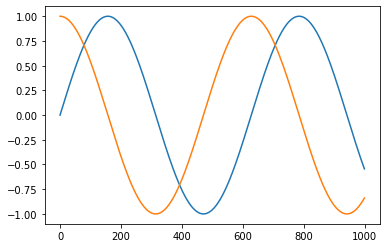

In [24]:
import matplotlib.pyplot as plt
from jax import vmap

t = jnp.linspace(0, 10, 1000)

plt.plot(jnp.sin(t))
plt.plot(vmap(grad(jnp.sin))(t))


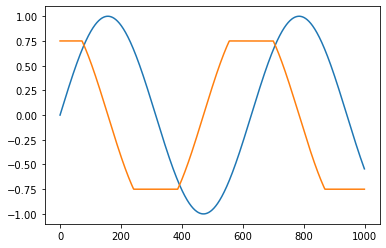

In [25]:
def clip_sin(x):
  x = clip_gradient(-0.75, 0.75, x)
  return jnp.sin(x)

plt.plot(clip_sin(t))
plt.plot(vmap(grad(clip_sin))(t))


### Python 调试

另一个由开发工作流程而非数值驱动的应用是在反向模式自动微分的反向传播中设置 `pdb` 调试器跟踪。


在尝试追踪 `nan` 运行时错误的来源，或者仔细检查传播的余切（梯度）值时，在反向传递的某个点插入调试器以对应于原始计算中的特定点会很有用。你可以使用 `jax.custom_vjp` 来实现这一点。

我们将在下一部分延迟一个示例。


### 迭代实现的隐函数微分

这个例子在数学上相当复杂！


另一个 `jax.custom_vjp` 的应用是对可以被 JAX 转换（通过 `jit`、`vmap` 等）但由于某些原因（例如涉及 `lax.while_loop`）而无法高效地进行 JAX 微分的函数进行反向模式微分。因为要有效计算 XLA HLO While 循环的反向模式导数，必须有一个内存使用无限的程序，而在 XLA HLO 中无法表达这种情况，至少在没有通过输入/输出的副作用交互的情况下是无法表达的。

例如，考虑这个 `fixed_point` 例程，它通过在 `while_loop` 中迭代应用一个函数来计算一个不动点：


In [26]:
from jax.lax import while_loop

def fixed_point(f, a, x_guess):
  def cond_fun(carry):
    x_prev, x = carry
    return jnp.abs(x_prev - x) > 1e-6

  def body_fun(carry):
    _, x = carry
    return x, f(a, x)

  _, x_star = while_loop(cond_fun, body_fun, (x_guess, f(a, x_guess)))
  return x_star


这是一个迭代过程，旨在通过迭代 $x_{t+1} = f(a, x_t)$ 数值求解方程 $x = f(a, x)$ 中的 $x$，直到 $x_{t+1}$ 足够接近 $x_t$。结果 $x^*$ 依赖于参数 $a$，因此我们可以认为存在一个通过方程 $x = f(a, x)$ 隐式定义的函数 $a \mapsto x^*(a)$。

我们可以使用 `fixed_point` 来运行迭代过程直到收敛，例如运行牛顿方法计算平方根，同时仅执行加法、乘法和除法：


In [27]:
def newton_sqrt(a):
  update = lambda a, x: 0.5 * (x + a / x)
  return fixed_point(update, a, a)


In [28]:
print(newton_sqrt(2.))


1.4142135


我们可以对这个函数使用 `vmap` 或 `jit`：


In [29]:
print(jit(vmap(newton_sqrt))(jnp.array([1., 2., 3., 4.])))


[1.        1.4142135 1.7320508 2.       ]


我们无法应用反向模式自动微分，原因在于 `while_loop`，但事实证明我们也不想这么做：与其通过 `fixed_point` 的实现及其所有迭代进行微分，我们可以利用数学结构做一些更加节省内存的事情（在这种情况下，也更高效于浮点运算！）。我们可以使用隐函数定理 [参考Bertsekas的《非线性计划》，第二版 Prop A.25]，该定理保证（在某些条件下）我们即将使用的数学对象的存在。其实质是我们在解处线性化，并迭代地求解这些线性方程以计算我们想要的导数。

再考虑一下方程 $x = f(a, x)$ 和函数 $x^*$。我们想评估向量-雅可比积，例如 $v^\mathsf{T} \mapsto v^\mathsf{T} \partial x^*(a_0)$。

至少在我们想要微分的点 $a_0$ 的开邻域中，我们假设方程 $x^*(a) = f(a, x^*(a))$ 对所有 $a$ 都成立。由于两边作为 $a$ 的函数相等，所以它们的导数也必须相等，因此我们对两边进行微分：

$\qquad \partial x^*(a) = \partial_0 f(a, x^*(a)) + \partial_1 f(a, x^*(a))  \partial x^*(a)$。

设 $A = \partial_1 f(a_0, x^*(a_0))$ 和 $B = \partial_0 f(a_0, x^*(a_0))$，我们可以将我们所需的量更简单地写为

$\qquad \partial x^*(a_0) = B + A \partial x^*(a_0)$，

或者，通过重新排列，

$\qquad \partial x^*(a_0) = (I - A)^{-1} B$。

这意味着我们可以评估向量-雅可比积，例如

$\qquad v^\mathsf{T} \partial x^*(a_0) = v^\mathsf{T} (I - A)^{-1} B = w^\mathsf{T} B$，

其中 $w^\mathsf{T} = v^\mathsf{T} (I - A)^{-1}$，或者等效地 $w^\mathsf{T} = v^\mathsf{T} + w^\mathsf{T} A$，换句话说，$w^\mathsf{T}$ 是映射 $u^\mathsf{T} \mapsto v^\mathsf{T} + u^\mathsf{T} A$ 的不动点。最后这个表述为我们提供了一种将 `fixed_point` 的 VJP 表述为对 `fixed_point` 的调用的方法！而且，在将 $A$ 和 $B$ 回展开之后，我们可以看到我们仅需在 $(a_0, x^*(a_0))$ 处评估 $f$ 的 VJP。

结论是：


In [30]:
from jax import vjp

@partial(custom_vjp, nondiff_argnums=(0,))
def fixed_point(f, a, x_guess):
  def cond_fun(carry):
    x_prev, x = carry
    return jnp.abs(x_prev - x) > 1e-6

  def body_fun(carry):
    _, x = carry
    return x, f(a, x)

  _, x_star = while_loop(cond_fun, body_fun, (x_guess, f(a, x_guess)))
  return x_star

def fixed_point_fwd(f, a, x_init):
  x_star = fixed_point(f, a, x_init)
  return x_star, (a, x_star)

def fixed_point_rev(f, res, x_star_bar):
  a, x_star = res
  _, vjp_a = vjp(lambda a: f(a, x_star), a)
  a_bar, = vjp_a(fixed_point(partial(rev_iter, f),
                             (a, x_star, x_star_bar),
                             x_star_bar))
  return a_bar, jnp.zeros_like(x_star)

def rev_iter(f, packed, u):
  a, x_star, x_star_bar = packed
  _, vjp_x = vjp(lambda x: f(a, x), x_star)
  return x_star_bar + vjp_x(u)[0]

fixed_point.defvjp(fixed_point_fwd, fixed_point_rev)


In [31]:
print(newton_sqrt(2.))


1.4142135


In [32]:
print(grad(newton_sqrt)(2.))
print(grad(grad(newton_sqrt))(2.))


0.35355335
-0.088388346


我们可以通过对 `jnp.sqrt` 进行求导来检查我们的答案，它使用完全不同的实现：


In [33]:
print(grad(jnp.sqrt)(2.))
print(grad(grad(jnp.sqrt))(2.))


0.35355338
-0.08838835


这种方法的一个限制是，参数 `f` 不能捕获任何涉及微分的值。也就是说，你可能注意到我们在 `fixed_point` 的参数列表中保持了参数 `a` 的显式。对于这种用途，可以考虑使用底层原语 `lax.custom_root`，它允许在闭合变量中进行微分，并且支持自定义根查找函数。


## `jax.custom_jvp` 和 `jax.custom_vjp` API 的基本用法


### 使用 `jax.custom_jvp` 定义正向模式（以及间接的反向模式）规则

这是一个使用 `jax.custom_jvp` 的经典基本示例，其中注释使用
[类似 Haskell 的类型签名](https://wiki.haskell.org/Type_signature)：


In [34]:
from jax import custom_jvp
import jax.numpy as jnp

# f :: a -> b
@custom_jvp
def f(x):
  return jnp.sin(x)

# f_jvp :: (a, T a) -> (b, T b)
def f_jvp(primals, tangents):
  x, = primals
  t, = tangents
  return f(x), jnp.cos(x) * t

f.defjvp(f_jvp)


In [35]:
from jax import jvp

print(f(3.))

y, y_dot = jvp(f, (3.,), (1.,))
print(y)
print(y_dot)


0.14112
0.14112
-0.9899925


用文字来说，我们从一个原始函数 `f` 开始，该函数接受类型为 `a` 的输入并产生类型为 `b` 的输出。我们将其关联一个 JVP 规则函数 `f_jvp`，该函数接受一对输入，表示原始输入类型为 `a` 和相应的切线输入类型为 `T a`，并产生一对输出，表示原始输出类型为 `b` 和切线输出类型为 `T b`。切线输出应该是切线输入的线性函数。


您还可以将 `f.defjvp` 作为修饰符使用，如下所示：

```python
@custom_jvp
def f(x):
  ...

@f.defjvp
def f_jvp(primals, tangents):
  ...
```


尽管我们只定义了 JVP 规则而没有 VJP 规则，但我们可以对 `f` 使用前向和反向模式的微分。JAX 将自动转置我们自定义 JVP 规则上的切线值的线性计算，以与我们手动编写规则时一样高效地计算 VJP：


In [36]:
from jax import grad

print(grad(f)(3.))
print(grad(grad(f))(3.))


-0.9899925
-0.14112


为了使自动转置正常工作，JVP规则的输出切向量必须是输入切向量的线性函数。否则会引发转置错误。


多个参数的工作方式如下：


In [37]:
@custom_jvp
def f(x, y):
  return x ** 2 * y

@f.defjvp
def f_jvp(primals, tangents):
  x, y = primals
  x_dot, y_dot = tangents
  primal_out = f(x, y)
  tangent_out = 2 * x * y * x_dot + x ** 2 * y_dot
  return primal_out, tangent_out


In [38]:
print(grad(f)(2., 3.))


12.0


`defjvps` 便利包装器允许我们为每个参数单独定义 JVP，然后分别计算结果并求和：


In [39]:
@custom_jvp
def f(x):
  return jnp.sin(x)

f.defjvps(lambda t, ans, x: jnp.cos(x) * t)


In [40]:
print(grad(f)(3.))


-0.9899925


这是一个带有多个参数的 `defjvps` 示例：


In [41]:
@custom_jvp
def f(x, y):
  return x ** 2 * y

f.defjvps(lambda x_dot, primal_out, x, y: 2 * x * y * x_dot,
          lambda y_dot, primal_out, x, y: x ** 2 * y_dot)


In [42]:
print(grad(f)(2., 3.))
print(grad(f, 0)(2., 3.))  # 同上
print(grad(f, 1)(2., 3.))


12.0
12.0
4.0


作为简写，使用 `defjvps` 可以传递一个 `None` 值来表示特定参数的 JVP 为零：


In [43]:
@custom_jvp
def f(x, y):
  return x ** 2 * y

f.defjvps(lambda x_dot, primal_out, x, y: 2 * x * y * x_dot,
          None)


In [44]:
print(grad(f)(2., 3.))
print(grad(f, 0)(2., 3.))  # 同上
print(grad(f, 1)(2., 3.))


12.0
12.0
0.0


调用 `jax.custom_jvp` 函数时使用关键词参数，或者在定义 `jax.custom_jvp` 函数时使用默认参数，都是允许的，只要它们能够根据标准库 `inspect.signature` 机制检索到的函数签名明确地映射到位置参数。


当你不执行微分时，函数 `f` 的调用就像它没有被 `jax.custom_jvp` 装饰一样：


In [45]:
@custom_jvp
def f(x):
  print('called f!')  # 一个无害的副作用
  return jnp.sin(x)

@f.defjvp
def f_jvp(primals, tangents):
  print('called f_jvp!')  # 一个无害的副作用
  x, = primals
  t, = tangents
  return f(x), jnp.cos(x) * t


In [46]:
from jax import vmap, jit

print(f(3.))


called f!
0.14112


In [47]:
print(vmap(f)(jnp.arange(3.)))
print(jit(f)(3.))


called f!
[0.        0.841471  0.9092974]
called f!
0.14112


自定义JVP规则在微分时被调用，无论是正向还是反向：


In [48]:
y, y_dot = jvp(f, (3.,), (1.,))
print(y_dot)


called f_jvp!
called f!
-0.9899925


In [49]:
print(grad(f)(3.))


called f_jvp!
called f!
-0.9899925


注意到 `f_jvp` 调用 `f` 来计算原始输出。在高阶微分的上下文中，每次应用微分变换时，只有在规则调用原始 `f` 来计算原始输出时，自定义 JVP 规则才会被使用。（这代表了一种基本的权衡，即我们不能在规则中同时利用 `f` 评估的中间值，同时又让规则在所有高阶微分中都适用。）


In [50]:
grad(grad(f))(3.)


called f_jvp!
called f_jvp!
called f!


Array(-0.14112, dtype=float32)

您可以使用`jax.custom_jvp`进行Python控制流：


In [51]:
@custom_jvp
def f(x):
  if x > 0:
    return jnp.sin(x)
  else:
    return jnp.cos(x)

@f.defjvp
def f_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = f(x)
  if x > 0:
    return ans, 2 * x_dot
  else:
    return ans, 3 * x_dot


In [52]:
print(grad(f)(1.))
print(grad(f)(-1.))


2.0
3.0


### 使用 `jax.custom_vjp` 定义自定义反向模式规则

虽然 `jax.custom_jvp` 足以控制正向和通过 JAX 的自动转置实现的反向模式微分行为，但在某些情况下，我们可能希望直接控制 VJP 规则，例如在上述最后两个示例问题中。我们可以通过 `jax.custom_vjp` 来实现这一点：


In [53]:
from jax import custom_vjp
import jax.numpy as jnp

# f :: a -> b
@custom_vjp
def f(x):
  return jnp.sin(x)

# f_fwd :: a -> (b, c)
def f_fwd(x):
  return f(x), jnp.cos(x)

# f_bwd :: (c, CT b) -> CT a
def f_bwd(cos_x, y_bar):
  return (cos_x * y_bar,)

f.defvjp(f_fwd, f_bwd)


In [54]:
from jax import grad

print(f(3.))
print(grad(f)(3.))


0.14112
-0.9899925


用语言描述，我们再次从一个原始函数 `f` 开始，该函数接受类型为 `a` 的输入并产生类型为 `b` 的输出。我们与其关联两个函数，`f_fwd` 和 `f_bwd`，分别描述如何执行反向模式自动微分的前向传播和后向传播。

函数 `f_fwd` 描述前向传播，不仅包括原始计算，还包括在后向传播中要保存的值。它的输入签名与原始函数 `f` 的输入签名相同，接收类型为 `a` 的原始输入。作为输出，它产生一对，其中第一个元素是原始输出 `b`，第二个元素是任何类型为 `c` 的“残余”数据，供后向传播使用。（这个第二个输出类似于 [PyTorch 的 save_for_backward 机制](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html)。）

函数 `f_bwd` 描述后向传播。它接受两个输入，第一个是由 `f_fwd` 生成的类型为 `c` 的残余数据，第二个是与原始函数输出对应的类型为 `CT b` 的输出余切。它产生类型为 `CT a` 的输出，表示与原始函数输入对应的余切。特别地，`f_bwd` 的输出必须是一个序列（例如元组），其长度等于原始函数的参数数量。


多个参数的工作原理如下：


In [55]:
from jax import custom_vjp

@custom_vjp
def f(x, y):
  return jnp.sin(x) * y

def f_fwd(x, y):
  return f(x, y), (jnp.cos(x), jnp.sin(x), y)

def f_bwd(res, g):
  cos_x, sin_x, y = res
  return (cos_x * g * y, sin_x * g)

f.defvjp(f_fwd, f_bwd)


In [56]:
print(grad(f)(2., 3.))


-1.2484405


调用 `jax.custom_vjp` 函数时使用关键字参数，或编写带有默认参数的 `jax.custom_vjp` 函数定义，都是允许的，只要它们可以根据标准库 `inspect.signature` 机制检索到的函数签名明确映射到位置参数。


与 `jax.custom_jvp` 一样，如果未应用微分，则由 `f_fwd` 和 `f_bwd` 组成的自定义 VJP 规则不会被调用。如果函数被评估或使用 `jit`、`vmap` 或其他非微分转换进行转换，则只调用 `f`。


In [57]:
@custom_vjp
def f(x):
  print("called f!")
  return jnp.sin(x)

def f_fwd(x):
  print("called f_fwd!")
  return f(x), jnp.cos(x)

def f_bwd(cos_x, y_bar):
  print("called f_bwd!")
  return (cos_x * y_bar,)

f.defvjp(f_fwd, f_bwd)


In [58]:
print(f(3.))


called f!
0.14112


In [59]:
print(grad(f)(3.))


called f_fwd!
called f!
called f_bwd!
-0.9899925


In [60]:

y, f_vjp = vjp(f, 3.)
print(y)


called f_fwd!
called f!
0.14112


In [61]:
print(f_vjp(1.))


called f_bwd!
(Array(-0.9899925, dtype=float32),)


**前向模式自动微分不能用于** `jax.custom_vjp` **函数**，并会引发错误：


In [62]:
from jax import jvp

try:
  jvp(f, (3.,), (1.,))
except TypeError as e:
  print('ERROR! {}'.format(e))


called f_fwd!
called f!
ERROR! can't apply forward-mode autodiff (jvp) to a custom_vjp function.


如果您想同时使用正向模式和反向模式，请使用 `jax.custom_jvp`。


我们可以将 `jax.custom_vjp` 与 `pdb` 结合使用，在反向传播中插入调试器跟踪：


In [63]:
import pdb

@custom_vjp
def debug(x):
  return x  # 行为如同身份

def debug_fwd(x):
  return x, x

def debug_bwd(x, g):
  pdb.set_trace()
  return g

debug.defvjp(debug_fwd, debug_bwd)


In [64]:
def foo(x):
  y = x ** 2
  y = debug(y)  # 在相应的反向传播步骤中插入pdb
  return jnp.sin(y)


```markdown
# 计算梯度

我们可以使用 `jax.grad` 来计算函数 `foo` 在点 3.0 处的梯度。
```


## 更多功能和细节


### 使用 `list` / `tuple` / `dict` 容器（以及其他 pytrees）

您应该期望标准的 Python 容器，例如列表、元组、命名元组和字典，以及它们的嵌套版本可以正常使用。一般来说，任何 [pytrees](https://jax.readthedocs.io/en/latest/pytrees.html) 都是被允许的，只要它们的结构符合类型约束。

以下是一个使用 `jax.custom_jvp` 的虚构示例：


In [65]:
from collections import namedtuple
Point = namedtuple("Point", ["x", "y"])

@custom_jvp
def f(pt):
  x, y = pt.x, pt.y
  return {'a': x ** 2,
          'b': (jnp.sin(x), jnp.cos(y))}

@f.defjvp
def f_jvp(primals, tangents):
  pt, = primals
  pt_dot, =  tangents
  ans = f(pt)
  ans_dot = {'a': 2 * pt.x * pt_dot.x,
             'b': (jnp.cos(pt.x) * pt_dot.x, -jnp.sin(pt.y) * pt_dot.y)}
  return ans, ans_dot

def fun(pt):
  dct = f(pt)
  return dct['a'] + dct['b'][0]


In [66]:
pt = Point(1., 2.)

print(f(pt))


{'a': 1.0, 'b': (Array(0.841471, dtype=float32), Array(-0.4161468, dtype=float32))}


In [67]:
print(grad(fun)(pt))


Point(x=Array(2.5403023, dtype=float32), y=array(0., dtype=float32))


以及一个类似的虚构示例，使用 `jax.custom_vjp`：


In [68]:
@custom_vjp
def f(pt):
  x, y = pt.x, pt.y
  return {'a': x ** 2,
          'b': (jnp.sin(x), jnp.cos(y))}

def f_fwd(pt):
  return f(pt), pt

def f_bwd(pt, g):
  a_bar, (b0_bar, b1_bar) = g['a'], g['b']
  x_bar = 2 * pt.x * a_bar + jnp.cos(pt.x) * b0_bar
  y_bar = -jnp.sin(pt.y) * b1_bar
  return (Point(x_bar, y_bar),)

f.defvjp(f_fwd, f_bwd)

def fun(pt):
  dct = f(pt)
  return dct['a'] + dct['b'][0]


In [69]:
pt = Point(1., 2.)

print(f(pt))


{'a': 1.0, 'b': (Array(0.841471, dtype=float32), Array(-0.4161468, dtype=float32))}


In [70]:
print(grad(fun)(pt))


Point(x=Array(2.5403023, dtype=float32), y=Array(-0., dtype=float32))


### 处理不可微分的参数


某些用例，例如最后的示例问题，需要将不可微的参数（如以函数为值的参数）传递给具有自定义微分规则的函数，并且这些参数也需要传递给微分规则本身。在 `fixed_point` 的情况下，函数参数 `f` 就是这样一个不可微的参数。`jax.experimental.odeint` 也会出现类似的情况。


#### `jax.custom_jvp` 与 `nondiff_argnums`

使用可选的 `nondiff_argnums` 参数来指示像这样的参数。以下是使用 `jax.custom_jvp` 的示例：


In [71]:
from functools import partial

@partial(custom_jvp, nondiff_argnums=(0,))
def app(f, x):
  return f(x)

@app.defjvp
def app_jvp(f, primals, tangents):
  x, = primals
  x_dot, = tangents
  return f(x), 2. * x_dot


In [72]:
print(app(lambda x: x ** 3, 3.))


27.0


In [73]:
print(grad(app, 1)(lambda x: x ** 3, 3.))


2.0


注意这里的陷阱：无论这些参数在参数列表中的位置如何，它们都会被放置在相应JVP规则签名的*开头*。这是另一个例子：


In [74]:
@partial(custom_jvp, nondiff_argnums=(0, 2))
def app2(f, x, g):
  return f(g((x)))

@app2.defjvp
def app2_jvp(f, g, primals, tangents):
  x, = primals
  x_dot, = tangents
  return f(g(x)), 3. * x_dot


In [75]:
print(app2(lambda x: x ** 3, 3., lambda y: 5 * y))


3375.0


In [76]:
print(grad(app2, 1)(lambda x: x ** 3, 3., lambda y: 5 * y))


3.0


#### `jax.custom_vjp` 与 `nondiff_argnums`


`jax.custom_vjp` 也有类似的选项，类似地，不可微分的参数被作为 `_bwd` 规则的第一个参数传递，无论它们在原始函数签名中的位置如何。`_fwd` 规则的签名保持不变 - 它与原始函数的签名相同。以下是一个示例：


In [77]:
@partial(custom_vjp, nondiff_argnums=(0,))
def app(f, x):
  return f(x)

def app_fwd(f, x):
  return f(x), x

def app_bwd(f, x, g):
  return (5 * g,)

app.defvjp(app_fwd, app_bwd)


In [78]:
print(app(lambda x: x ** 2, 4.))


16.0


In [79]:
print(grad(app, 1)(lambda x: x ** 2, 4.))


5.0


请参见上面的 `fixed_point` 以获取另一个用法示例。

**您不需要对** `nondiff_argnums` **与数组值参数一起使用**，例如具有整数数据类型的参数。相反，`nondiff_argnums` 应仅用于与 JAX 类型不对应的参数值（本质上不对应于数组类型），例如 Python 可调用对象或字符串。如果 JAX 检测到 `nondiff_argnums` 指定的参数包含 JAX Tracer，则会引发错误。上面的 `clip_gradient` 函数是一个很好的示例，不需要对整数数据类型的数组参数使用 `nondiff_argnums`。
